# PA005 - High Value Customer Identification (Insiders)

# Planejanamento da solução (IoT)

## Input - Entrada
    

1. Problema do negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização

2. Conjunto de dados
    - Vendas de um e-commerce online durante o período de um ano

## Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider |
                10323  | yes/1
                32413  | no/1
                
                
2. Relatório
    1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    2. Quantos clientes farão parte do grupo?
    3. Quais as principais características desses clientes ?
    4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    7. Quais as condições para uma pessoa ser removida do Insiders ?
    8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento: 
        - Alto ticket médio.
        - Alto LTV (life time value).
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixo taxa de devolução
        
    - Experiência 
        - Média alta de avaliação
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de cliente
    - % do grupo de Insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente:
        Idade
        Localização
    - Escrever características do consumo:
        Atributos da clusterização
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort 
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo
    
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser dessimilar ou parecido com uma pessoa do grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frente
    - Visita a empresa

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import regex as re

import umap.umap_ as umap

#from pandas_profiling import ProfileReport

from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp

from plotly import express as px

from matplotlib import pyplot as plt

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/alex/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['re']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Load dataset

In [4]:
df_raw = pd.read_csv('datasets/Ecommerce.csv', encoding='unicode_escape')

#drop extra column
df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1 )

In [5]:
df_raw.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
30915,538883,21179,NO JUNK MAIL METAL SIGN,1,12-Dec-16,3.36,NaN,United Kingdom
441454,574575,21726,MULTI HEARTS STICKERS,10,2-Nov-17,0.85,14971.0,United Kingdom
48913,540480,21429,RED GINGHAM ROSE JEWELLERY BOX,8,5-Jan-17,1.65,12480.0,Germany
459632,575875,23398,HANGING HEART BONHEUR,2,9-Nov-17,2.08,NaN,United Kingdom
168133,551012,22728,ALARM CLOCK BAKELIKE PINK,1,24-Apr-17,8.29,NaN,United Kingdom
120198,546649,84510a,SET OF 4 ENGLISH ROSE COASTERS,2,13-Mar-17,2.46,NaN,United Kingdom
380160,569734,23397,FOOT STOOL HOME SWEET HOME,2,4-Oct-17,9.95,14538.0,United Kingdom
527691,580727,22074,6 RIBBONS SHIMMERING PINKS,8,3-Dec-17,1.25,14096.0,United Kingdom
279859,561369,21578,WOODLAND DESIGN COTTON TOTE BAG,2,24-Jul-17,4.96,NaN,United Kingdom
119754,546569,22651,GENTLEMAN SHIRT REPAIR KIT,12,13-Mar-17,0.85,14016.0,EIRE


# Descrição dos dados

In [6]:
df1 = df_raw.copy()

## Rename Columns

In [7]:
cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_news

## Data dimensions

In [8]:
df1.shape

(541909, 8)

## Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Data Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

#create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange( 19000, 19000+len(df_backup), 1)

#merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

#drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1)

In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## Change dtypes

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [14]:
#invoice_date
df1['invoice_date'] =pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributs

In [17]:
#Central Tendecy - média e mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - desvio, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


**Skew:** mostra a deformação da sua distribuição em relação a normal

    **Skew positiva:** deformação para a esquerda
    
    **Skew negativa:** deformação para a direita
    
**Kurtosis:** mostra o quão os dados estão concentrados.

    Quanto maior a kurtosis mais dados concentrados, ou seja o pico da curva será muito grande
    
    Quanto menor a kurtosis,mais dispersos estão os dados, ou seja, o pico da curva será menor

#### Numerical Attributs - Investigating

1. quantidade negativa (pode ser devolução)
2. preço unitário igual a zero (pode ser promoção?)


### Categorical Attributs

#### Invoice No

In [18]:
#problema: temos letras no meio dos números

df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]', x))), :]

print('Total number of invoices: {}'.format( len (df_letter_invoice)))
print('Total de número negativos no quantity: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity'] < 0])))

Total number of invoices: 9291
Total de número negativos no quantity: 9288


#### Stock Code

In [19]:
#check stock codes only caracters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [20]:
#delete description

#### Country

In [21]:
df1['country'].value_counts( normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [22]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# Filtragem de variáveis

In [23]:
df2 = df1.copy()

In [24]:
df2[df2['customer_id'] == 16446]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446


In [25]:
#===== Numerical Attribuets =====
#unit price > 0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

#stock code != [POST, D, M, DOT,CRUK]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


#description
df2 = df2.drop( columns='description', axis=1)

#country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

#quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

# Feature Engineering

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


## Feature Creation

In [28]:
#Ideias de variáveis a serem criadas
    #Quantidade de compras por mês, antes do dia 15 e depois do dia 15
    

In [29]:
#data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country' ], axis=1).drop_duplicates(ignore_index=True)

### Gross Revenue
Faturamento

In [30]:
#Gross Revenue (Faturamento)
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

#monetary (quanto essa pessoa gastou até o momento)
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')

/home/alex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Recency Day
Último dia que foi feita uma compra

In [31]:
# Recency - Last day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### Quantity of  purchased
Quantas compras a pessoa fez

In [32]:
#número de produtos
df_freq = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename( columns={'invoice_no': 'qtde_invoices'})
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### Quantity of items purchased
A quantidade de itens comprados

In [33]:
#número de produtos
df_freq = df2_purchase.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity': 'qtde_items'})
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### Quantity of products purchased

In [34]:
#número de produtos
df_freq = df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename( columns={'stock_code': 'qtde_products'})
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### Average Ticket Value

In [35]:
#avg ticket (ticket médio)
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### Average Recency Days

In [36]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: ( x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

#average recency
df_avg_recency_days = df_aux.groupby( 'customer_id').mean().reset_index()

#merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### Frequency Purchase

In [37]:
df_aux = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                  .groupby( 'customer_id')
                                                  .agg( max_ = ( 'invoice_date', 'max'),
                                                        min_ = ( 'invoice_date', 'min'),
                                                        days_ = ('invoice_date', lambda x: ((x.max() - x.min() ) .days)+1),
                                                        buy_ = ('invoice_no', 'count') ) ).reset_index()

#frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

#merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### Number of Returns

In [38]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={ 'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### Basket Size
Quantidade de itens por cesta (quantity)

In [39]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                          .agg( n_purchase= ('invoice_no', 'nunique'),
                                                                                n_products=( 'quantity', 'sum') ).reset_index())

#calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### Unique Basket Size
Quantidade de produtos distintos por compra

In [40]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                          .agg( n_purchase= ('invoice_no', 'nunique'),
                                                                                n_products=( 'stock_code', 'count') ).reset_index())

#calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [41]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000


# EDA (Explory Data Analysis)

In [42]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## Univariate Analysis
Investigar os outliers e tirar as sujeiros do datasets

**Métricas a serem observadas**

1. Clusters Coesos - Separados
2. Métricas

    . Min, Max, Range
    
    . Média e Mediana
    
    . Desvio Padrão e Variância
    
    . Coeficiente de Variação (CV )
    
    . Distribuição
     

In [43]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output_v3.html' )

Quanto maior o valor da kurtosis, maior a ponta do seu gráfico

Skewness - direita - positiva
         - esquerda- negativa

**Notes**
kurtosis - Quanto maior o valor, maior a ponta do seu gráfico

Skewness - direita - positiva - esquerda- negativa

1. Cluster Coesos - Separados
2. Métricas
    - min, max, range (dispersão)
    - média e mediana
    - desvio padrão e variância
    - coeficiente de variação (CV)
    - Distribuição

### Análise de outliers da variáveis

#### Gross Revenue

In [44]:
#os outliers presentes no gross revenue fazem sentido para o projeto de clusterização

#### Avg Ticket

In [45]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


In [46]:
df3[df3['customer_id'] == 16446]
#ele comprou 81 mil itens e devolveu todos eles, vale a pena manter esse customer no dataset?
#vamos remover esse usuario do dataset

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


#### Qtde items

In [47]:
df4[df4['qtde_items'] == 196844]

#é um cliente incomum, mas parece ser real

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.20339,288.0,2733.944444,28.611111


#### Frequency

In [48]:
df4[df4['customer_id'] == 17850]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.5,17.0,40.0,50.970588,8.735294


#### Avg basket Size

In [49]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


## Bivariate Analysis
Verificar a variabilidade das variáveis para definir a variável resposta

In [50]:
#sns.pairplot(df4)

In [51]:
#frequencia não varia, então provavelmente será removida
#avg ticket não varia

## Estudo do espaço

In [52]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

In [53]:
from sklearn import preprocessing as pp
from sklearn import decomposition as dd

In [54]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']])   
df43['recency_days']           = mm.fit_transform( df43[['recency_days']])
df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])
df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']])

In [55]:
df43.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037774,0.003595,0.094521,1.000000,0.004438,0.008317,0.025896
1,0.011559,0.150134,0.039024,0.007056,0.021695,0.003764,0.071918,0.001345,0.003883,0.025539,0.060260
2,0.024000,0.005362,0.068293,0.025538,0.029479,0.006010,0.060788,0.002052,0.005547,0.055623,0.048431
3,0.003375,0.254692,0.019512,0.002225,0.003446,0.007125,0.251142,0.000734,0.000000,0.014447,0.015400
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.065116,0.020822,0.003985,0.002441,0.004272,0.000000


### PCA

In [56]:
X = df43.copy()

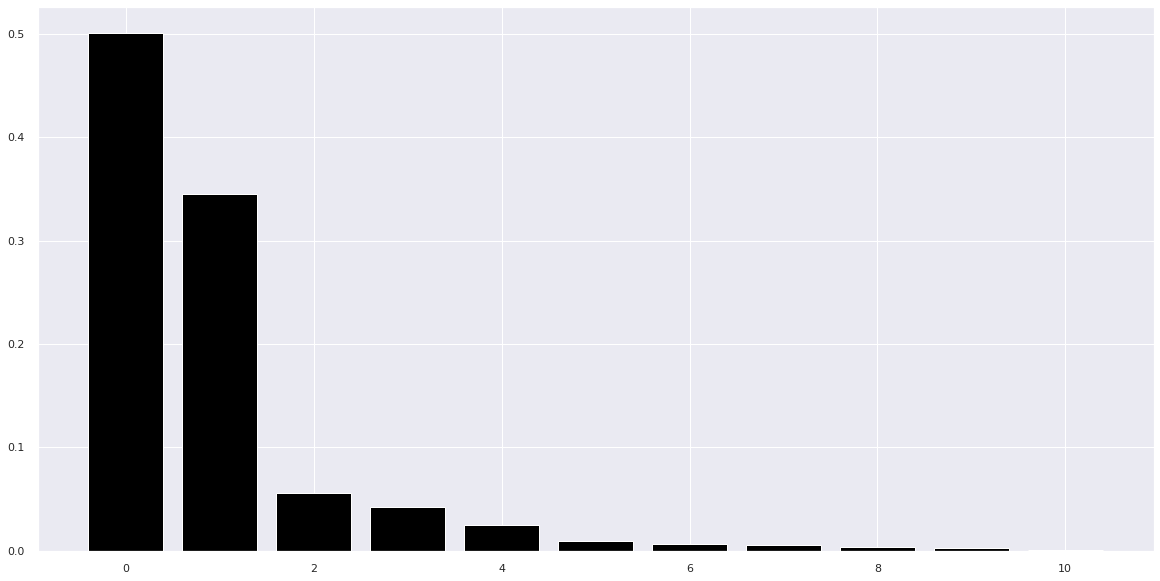

In [57]:
pca = dd.PCA( n_components=X.shape[1])
principal_components = pca.fit_transform( X )

#plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black')

#pca component
df_pca = pd.DataFrame( principal_components )


#Quais são os componentes principais com a maior variação de dados?

In [58]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.856032,-0.018812,0.044029,0.107500,-0.133846,0.051339,-0.187969,0.945359,0.038503,-0.014469,-0.004609
1,-0.009753,-0.112159,-0.014791,0.001501,-0.014563,0.003556,0.001827,-0.005974,0.000119,-0.002460,0.001494
2,-0.153573,-0.143660,-0.006941,0.037504,-0.005241,-0.001673,-0.014940,-0.002731,-0.007708,-0.008039,-0.002656
3,0.075950,0.079471,-0.053198,0.022318,-0.009963,-0.000009,0.000118,-0.006656,0.000901,-0.000394,0.000129
4,0.736572,-0.075301,-0.039715,0.035914,-0.010332,0.019321,0.008975,-0.030714,0.046648,-0.009171,-0.008011


<AxesSubplot:xlabel='0', ylabel='1'>

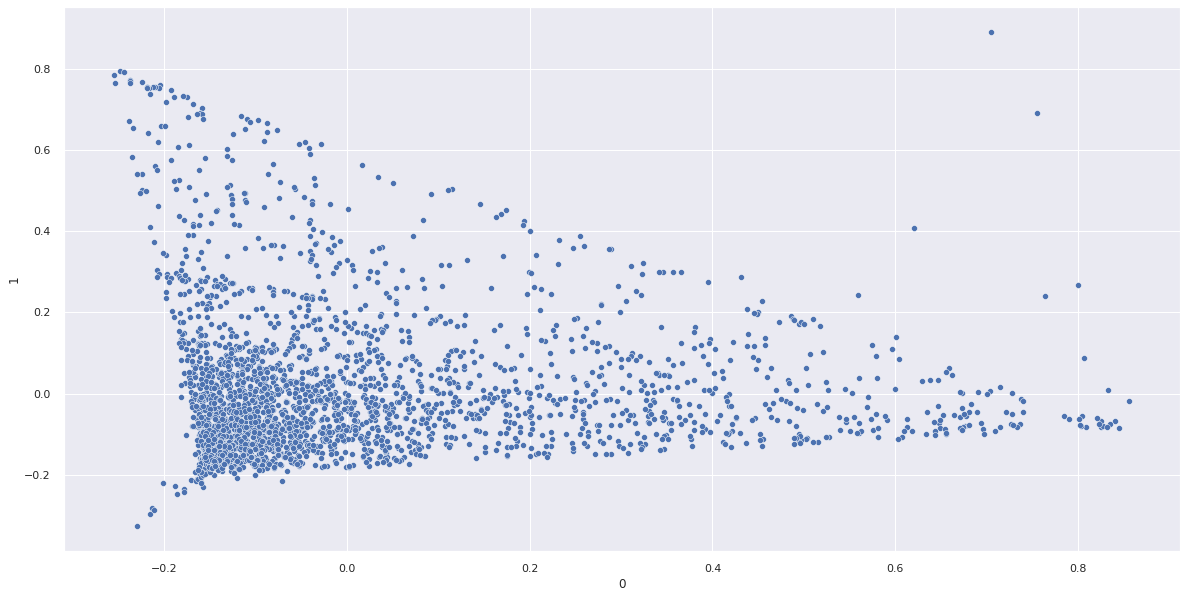

In [59]:
sns.scatterplot( x=0, y=1, data=df_pca)

### UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

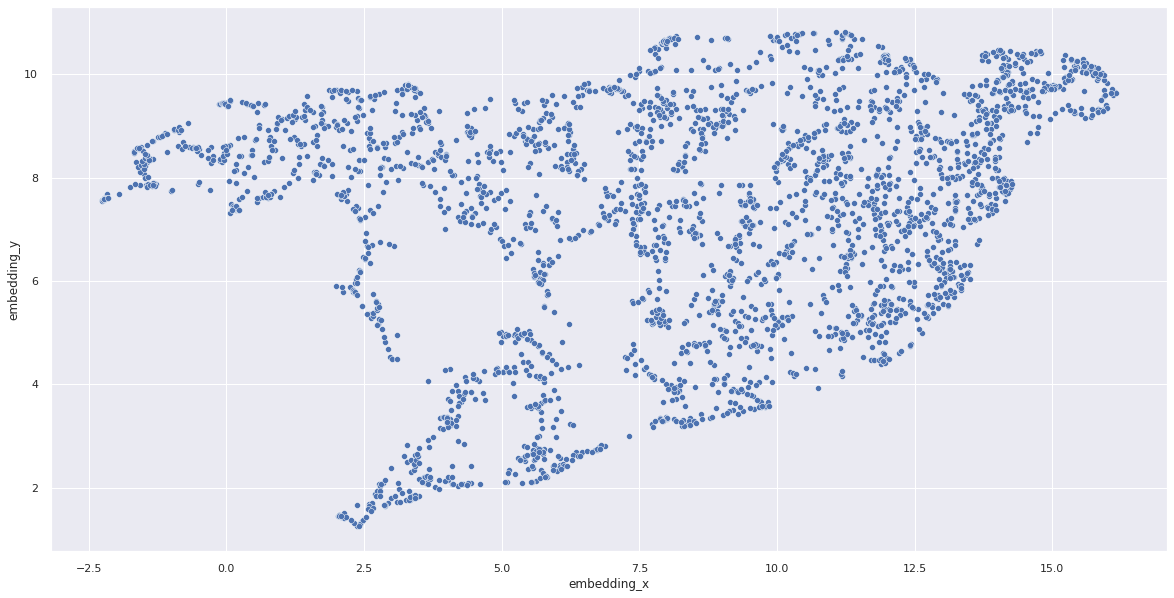

In [60]:
reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform( X )

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### t-SNE

In [61]:
from sklearn.manifold import TSNE

/home/alex/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

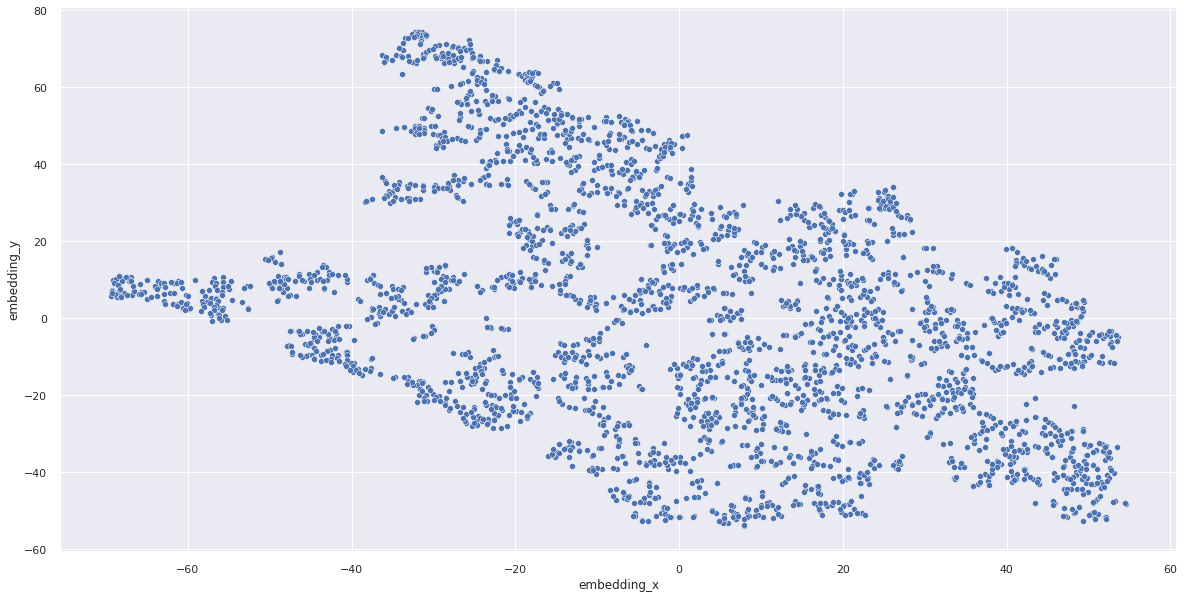

In [62]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform( X )

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### Tree-Based Embedding

In [63]:
from sklearn import ensemble as en

In [64]:
#training
X = df4.drop( columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

#model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42)

#model training
rf_model.fit(X, y)

#leaf

RandomForestRegressor(random_state=42)

In [65]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [66]:
X.shape

(2968, 10)

In [67]:
df_leaf.shape

(2968, 100)

In [68]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2991,3111,3388,3339,2762,3301,3223,3143,3175,3317,3156,3311,3070,3189,3130,3093,3012,3177,3104,3255,2914,3011,2905,3322,3355,3015,3036,2864,2928,3041,3318,3386,3132,3339,2947,3245,3411,3136,2957,3256,3366,3247,3220,3134,3182,3143,3287,3340,3348,3141,3193,2920,3135,3283,2975,3207,3167,3359,3220,2973,3421,3285,3337,3254,2715,3045,3235,3331,3062,3323,3304,2990,3318,3262,3116,3161,2955,3107,3219,3048,3235,3323,3137,3084,3295,3169,3353,3205,3132,3247,3185,3178,3218,3059,3041,3114,3212,2829,3357,3361
1,2961,2924,3045,2966,2752,2971,2895,2833,3113,2947,3102,2566,3063,3115,3047,3124,2980,3043,3066,2753,2797,3038,2758,2856,3020,3008,2795,2746,2841,3031,2869,3019,3046,2747,2908,2970,2845,2811,3056,2969,2687,2777,2992,3110,3113,3095,2912,2934,2976,3085,3166,3005,3057,3240,2929,2951,3124,3018,2861,2956,2994,2816,2897,2869,3004,3031,2890,2954,3044,2842,2859,2968,2964,2801,3063,2780,2902,3073,3161,3023,2918,2920,2983,2800,2905,3135,2948,3151,3092,2850,2515,2868,2946,2993,3140,3066,2907,2801,2976,3006
2,3632,3609,3586,3413,3572,3657,3630,3546,3680,3615,3625,3577,3533,3652,3565,3566,3582,3655,3555,3464,3513,3638,3604,3522,3569,3666,3574,3598,3591,3721,3438,3671,3598,3644,3574,3613,3543,3520,3599,3484,3657,3401,3615,3508,3520,3601,3425,3652,3634,3547,3632,3503,3566,3611,3666,3631,3609,3652,3573,3572,3613,3584,3573,3689,3456,3629,3652,3546,3554,3635,3588,3427,3576,3605,3545,3551,3597,3564,3536,3494,3536,3458,3478,3427,3518,3598,3581,3699,3600,3558,3599,3442,3560,3482,3601,3458,3525,3620,3568,3650
3,1287,1418,1754,1503,1912,2225,2112,1993,1638,1730,2051,2298,1346,1608,1527,1794,1903,1602,1424,1421,1833,1436,1468,1512,1145,1484,1512,1533,1663,1310,1950,1532,1512,1456,1049,1561,2168,2204,1662,1537,1505,1441,1462,1814,1396,1489,1551,1436,1379,1668,1832,1503,1354,1589,2105,1495,2012,1738,1298,2125,1601,1246,1889,1859,1482,1480,1407,1807,1067,1696,2303,1586,1285,2094,1272,2047,1517,1496,1925,1460,1922,1429,1348,1500,1486,1493,1401,1421,1671,1532,1904,1748,2041,1890,1970,2245,1508,1195,1998,2122
4,357,719,579,703,137,707,733,684,191,199,579,722,665,194,149,609,574,419,182,413,177,716,417,200,632,212,442,208,147,731,705,203,213,205,234,721,598,205,188,972,518,869,219,588,893,676,811,604,687,609,589,187,751,520,209,551,699,214,722,602,233,731,191,208,669,455,473,512,456,630,715,229,329,621,708,201,719,182,117,229,214,696,757,219,683,178,306,725,692,809,333,195,579,543,198,158,189,704,706,185


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

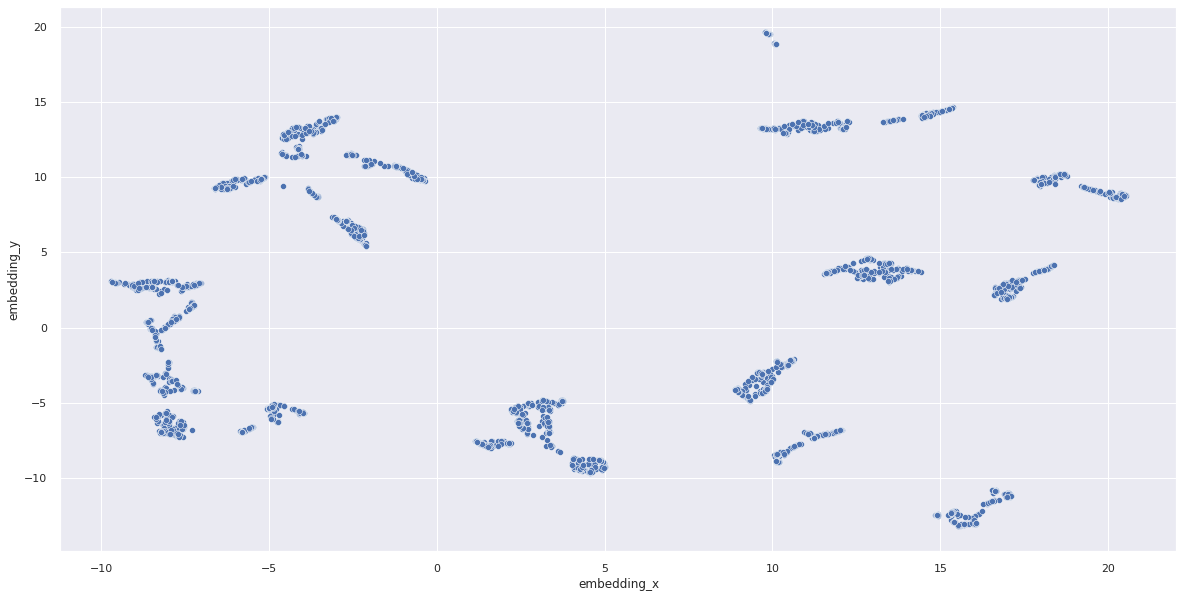

In [69]:
reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform( df_leaf )

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

# Data Preparation

In [70]:
df5 = df4.copy()

In [71]:
ss = pp.MinMaxScaler()

df5['gross_revenue']          = ss.fit_transform( df5[['gross_revenue']])
df5['recency_days']           = ss.fit_transform( df5[['recency_days']])
df5['qtde_invoices']          = ss.fit_transform( df5[['qtde_invoices']])
df5['qtde_items']             = ss.fit_transform( df5[['qtde_items']])
df5['qtde_products']          = ss.fit_transform( df5[['qtde_products']])
df5['avg_ticket']             = ss.fit_transform( df5[['avg_ticket']])
df5['avg_recency_days']       = ss.fit_transform( df5[['avg_recency_days']])
df5['frequency']              = ss.fit_transform( df5[['frequency']])
df5['qtde_returns']           = ss.fit_transform( df5[['qtde_returns']])
df5['avg_basket_size']        = ss.fit_transform( df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform( df5[['avg_unique_basket_size']])

In [72]:
df5.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.019292,0.997319,0.160976,0.008799,0.037774,0.003595,0.094521,1.000000,0.004438,0.008317,0.025896
1,13047,0.011559,0.150134,0.039024,0.007056,0.021695,0.003764,0.071918,0.001345,0.003883,0.025539,0.060260
2,12583,0.024000,0.005362,0.068293,0.025538,0.029479,0.006010,0.060788,0.002052,0.005547,0.055623,0.048431
3,13748,0.003375,0.254692,0.019512,0.002225,0.003446,0.007125,0.251142,0.000734,0.000000,0.014447,0.015400
4,15100,0.003116,0.892761,0.009756,0.000401,0.000255,0.065116,0.020822,0.003985,0.002441,0.004272,0.000000


# Feature Selection

In [120]:
df6 = df5.copy()

# Hyperparameter Fine-Tunning

In [121]:
X = df6.drop(columns=['customer_id'])

In [122]:
X.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037774,0.003595,0.094521,1.000000,0.004438,0.008317,0.025896
1,0.011559,0.150134,0.039024,0.007056,0.021695,0.003764,0.071918,0.001345,0.003883,0.025539,0.060260
2,0.024000,0.005362,0.068293,0.025538,0.029479,0.006010,0.060788,0.002052,0.005547,0.055623,0.048431
3,0.003375,0.254692,0.019512,0.002225,0.003446,0.007125,0.251142,0.000734,0.000000,0.014447,0.015400
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.065116,0.020822,0.003985,0.002441,0.004272,0.000000


In [123]:
X.shape

(2968, 11)

## K-Means

In [124]:
from sklearn import metrics as m

In [125]:
clusters = [2, 3, 4, 5, 6, 7]

In [126]:
x=0
kmeans_list=[]
for k in clusters:
    #model definition
    kmeans_model = c.KMeans( n_clusters=4)

    #model training
    kmeans_model.fit( X )

    #model predict
    labels = kmeans_model.predict( X )

    #model perfomance
    sil = m.silhouette_score( X, labels, metric='euclidean')
    kmeans_list.append(sil)
    


Text(0, 0.5, 'Silhouette Score')

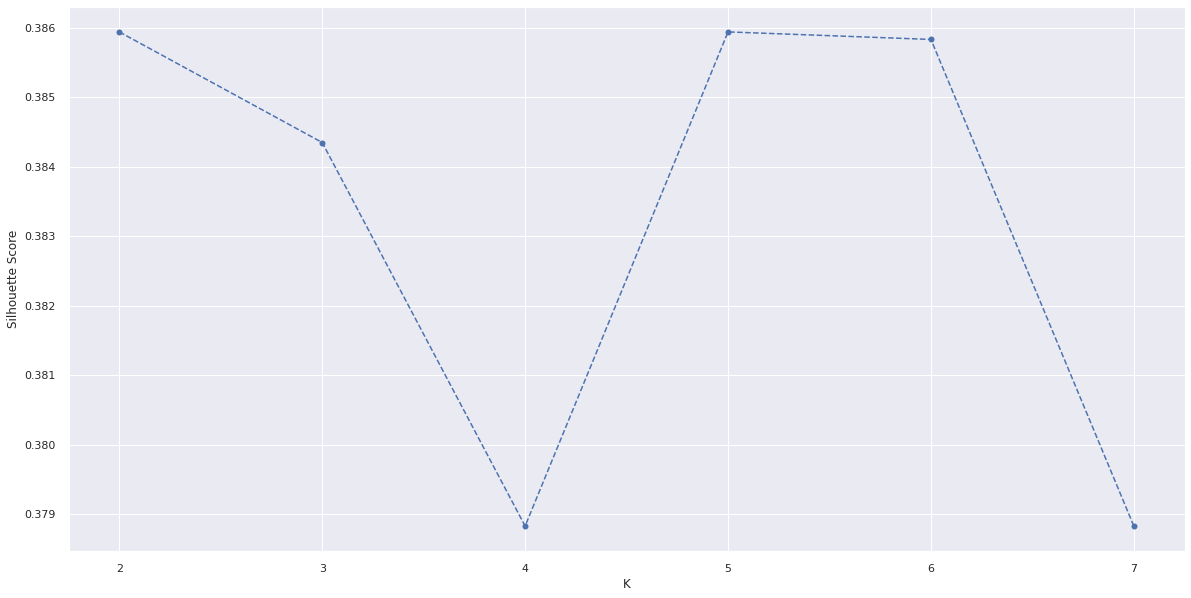

In [127]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

## GMM 

In [128]:
from sklearn import mixture as mx

In [129]:
gmm_list = []
for k in clusters:
    #model definition
    gmm_model = mx.GaussianMixture( n_components=2 )

    #model training
    gmm_model.fit(X)
    
    #model predict
    labels = gmm_model.predict( X )

    #model perfomance
    sil = m.silhouette_score( X, labels, metric='euclidean')
    gmm_list.append( sil )

Text(0, 0.5, 'Silhouette Score')

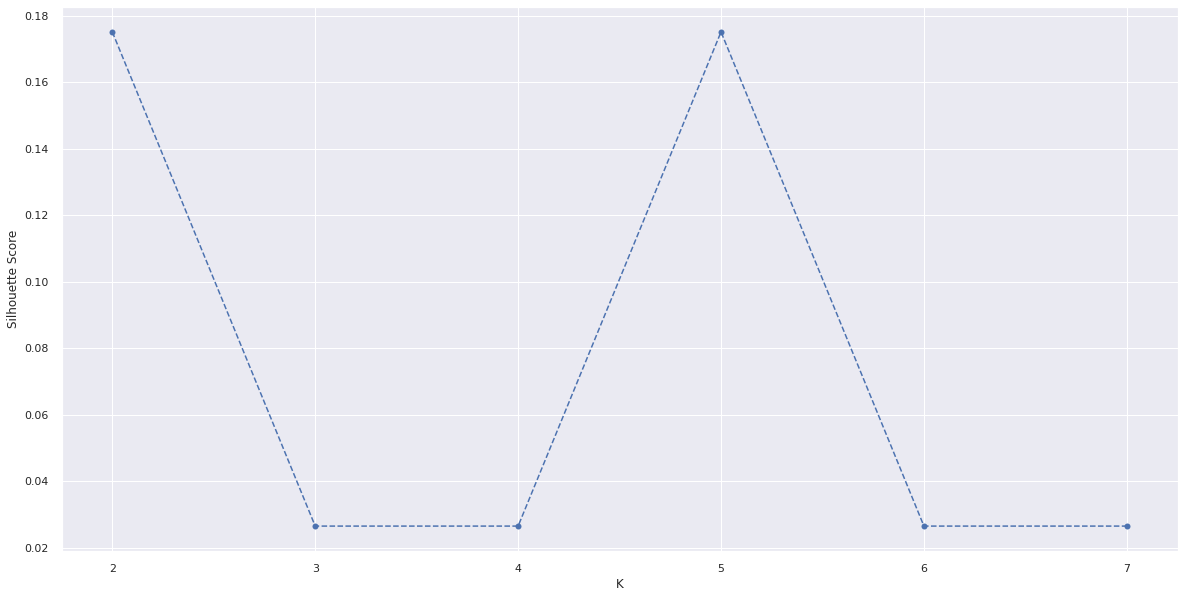

In [130]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

## Hierarchical Clustering 

In [131]:
from scipy.cluster import hierarchy as hc

In [132]:
hc_model = hc.linkage( X, 'ward')

[]

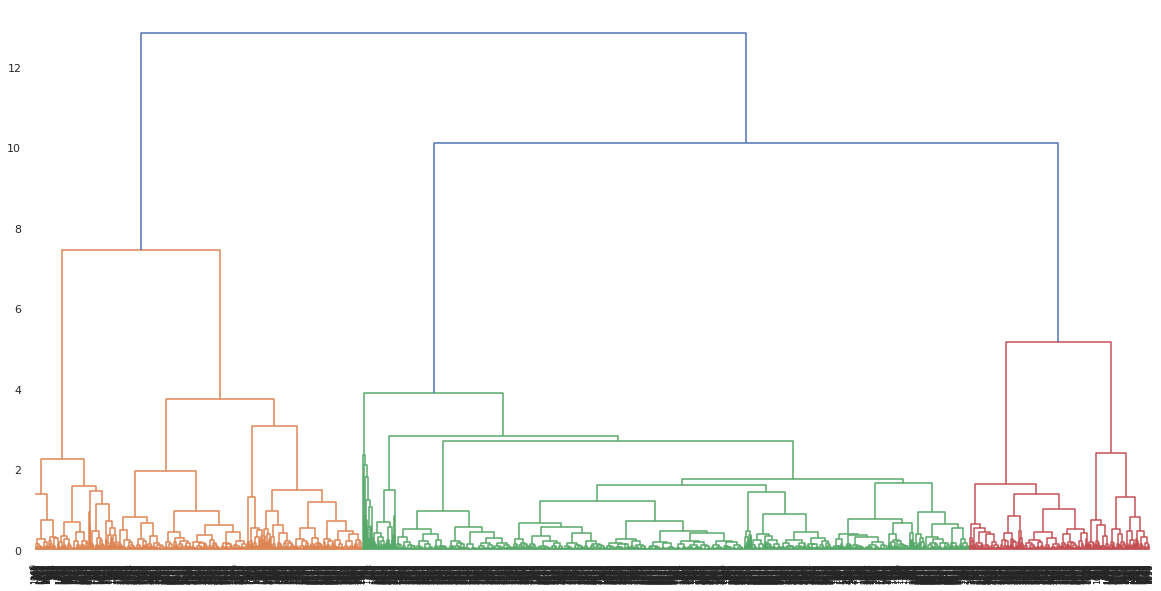

In [133]:
hc.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8)

plt.plot()

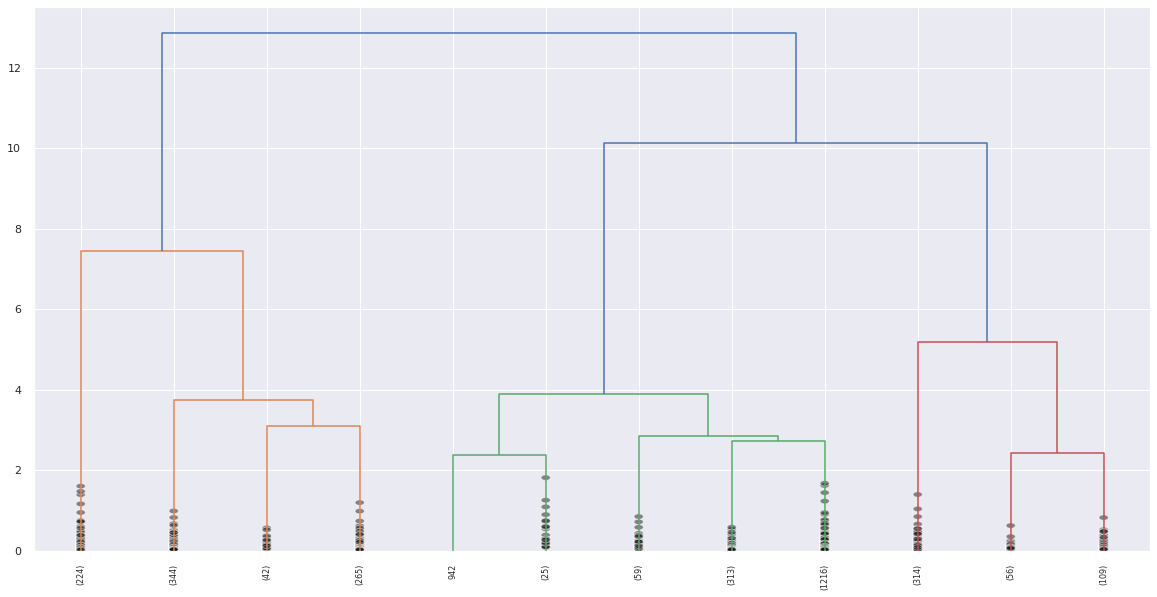

In [134]:
hc.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True)

plt.show()

### HClustering Sillhouette Score

In [135]:
hc_list = []
for k in clusters:
    #model definition & training
    hc_model = hc.linkage( X, 'ward')

    #model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    #metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append(sil)

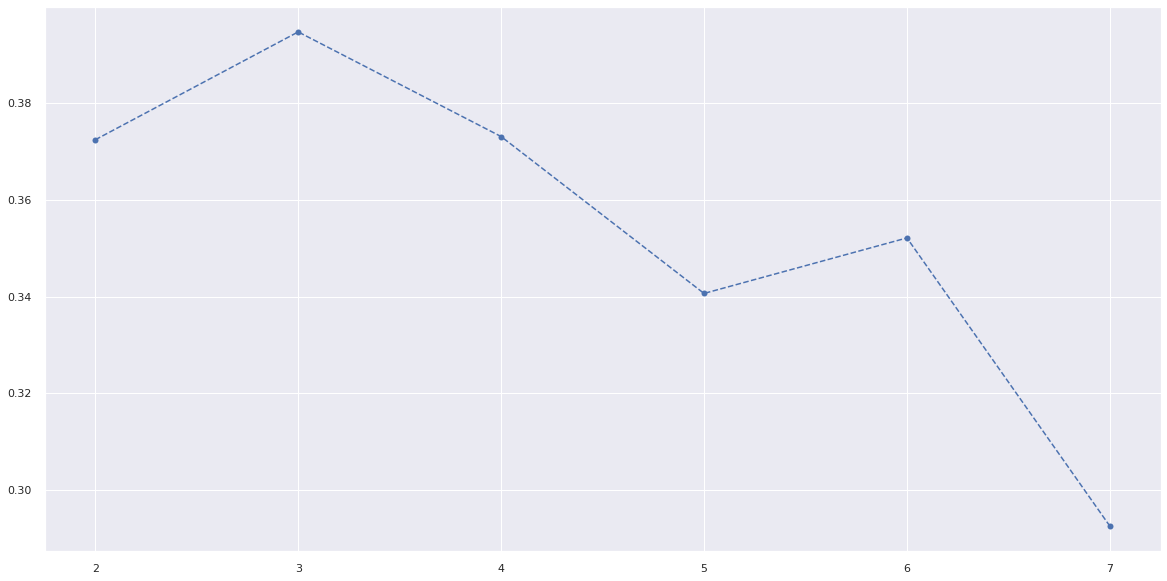

In [136]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b')

## DBSCAN 

In [90]:
eps=0.2
min_samples=20

#model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples)

#model training
labels = dbscan_model.fit_predict( X )

#metrics
sil = m.silhouette_score( X, labels, metric='euclidean')
print('Silhouette Score: {}'.format( sil ))
print( 'Number of Clusters: {}'.format(len(unique(labels))))

Silhouette Score: 0.6181122681752105
Number of Clusters: 2


In [91]:
unique( labels ) #k=2 -1=ruido

array([-1,  0])

In [92]:
from sklearn.neighbors import NearestNeighbors

In [93]:
neighbors = NearestNeighbors( n_neighbors = min_samples).fit( X )
distances, indices = neighbors.kneighbors( X )

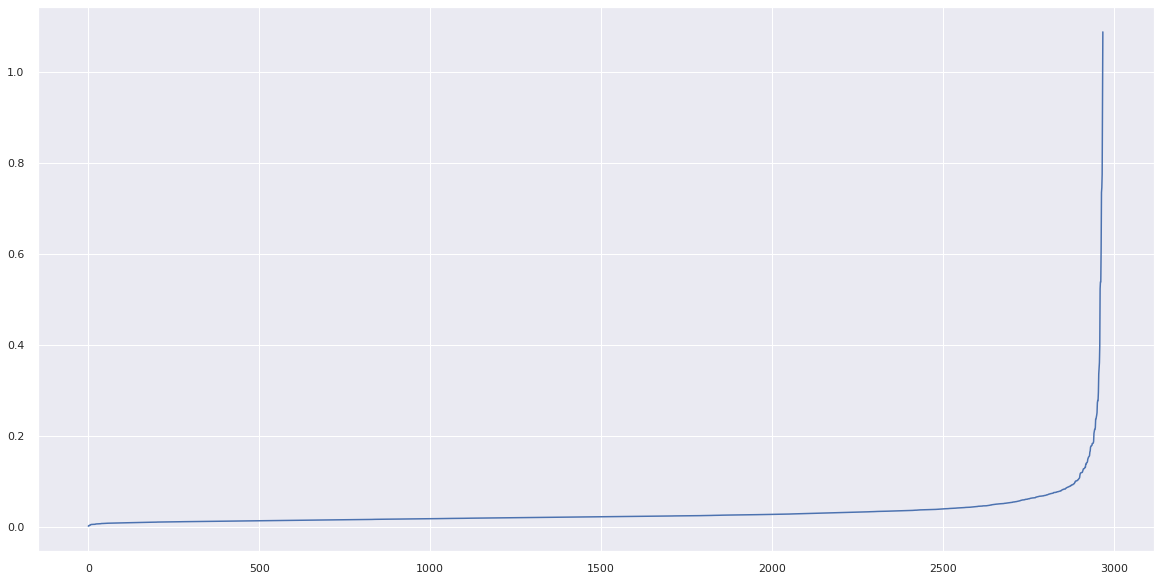

In [94]:
distances = np.sort( distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

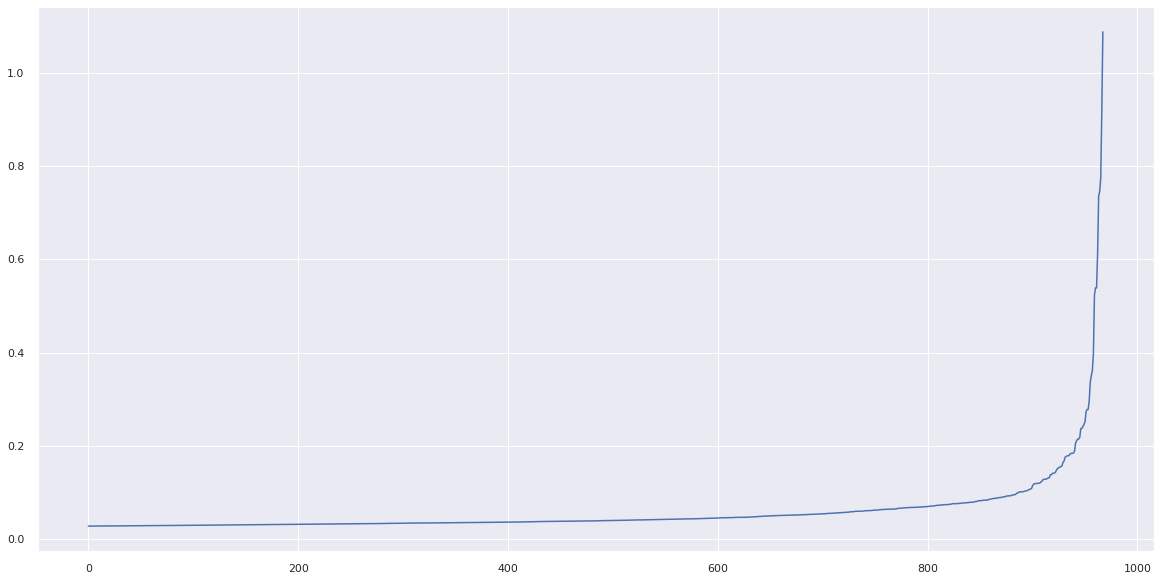

In [95]:
plt.plot(distances[2000:])

In [96]:
dbscan_list = [0.618112, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## Results 

In [97]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
      'GMM': gmm_list,
        'HC': hc_list,
        'DBSCAN': dbscan_list}).T

df_results.columns = clusters

In [98]:
df_results.style.highlight_max( color='lightgreen', axis=1)

,2,3,4,5,6,7
KMeans,0.378829,0.385943,0.378829,0.385995,0.385783,0.385783
GMM,0.026502,0.175188,0.026502,0.175188,0.175188,0.026502
HC,0.372480,0.394820,0.373142,0.340641,0.352141,0.292442
DBSCAN,0.618112,0.000000,0.000000,0.000000,0.000000,0.000000


##  Within-Cluster Sum of Square (Wss)

In [99]:
clusters = [2, 3, 4, 5, 6, 7]

Text(0.5, 1.0, 'WSS vs K')

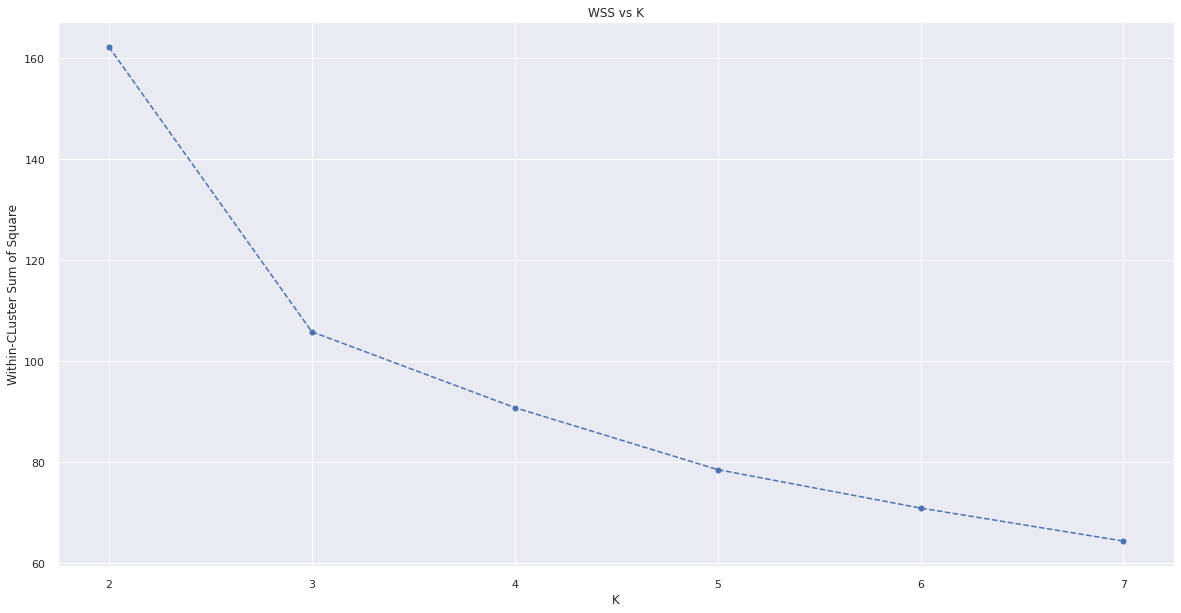

In [100]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans( init='random', n_clusters = k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit( X )
    
    #validation
    wss.append(kmeans.inertia_)
    
#plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-CLuster Sum of Square')
plt.title('WSS vs K')

## Sillhouette Analysis

For K = 2. Silhouette Score:0.37248008248117787
For K = 3. Silhouette Score:0.39481973999403247
For K = 4. Silhouette Score:0.37314233880042325
For K = 5. Silhouette Score:0.340640804966108
For K = 6. Silhouette Score:0.3521405101319263
For K = 7. Silhouette Score:0.29244152971739473


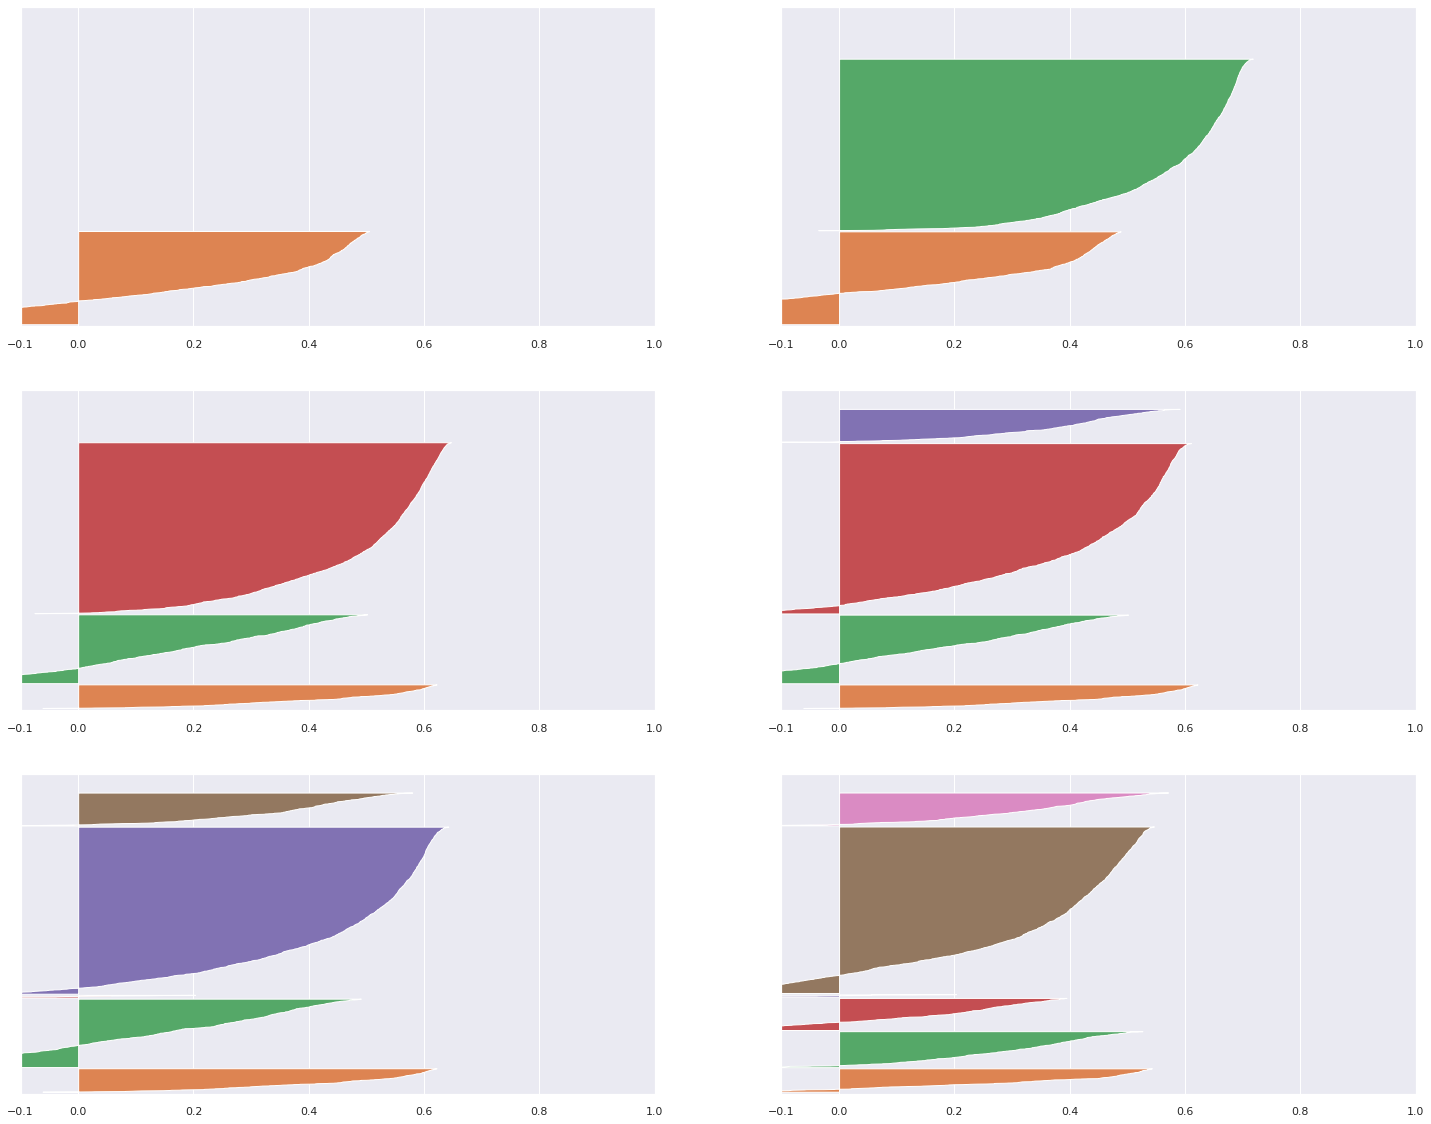

In [101]:
fig, ax = plt.subplots(3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2)
    
    ax[q-1, mod]. set_xlim( [-0.1, 1] )
    ax[q-1, mod]. set_ylim( [ 0, len(X) + (k+1)*10] )
    
    #model definition & training
    hc_model = hc.linkage( X, 'ward')

    #model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust')

    #performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print('For K = {}. Silhouette Score:{}'.format(k, ss))

    samples_silhouette_values = m.silhouette_samples( X, labels)



    y_lower = 10
    for i in range ( k ):


        #select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        #sort values
        ith_samples_silhouette_values.sort()        

        #size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        

        #limits
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap('Spectral')
        color = cmap( i/ k )

        ax[q-1, mod].fill_betweenx( np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        y_lower = y_upper + 10
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

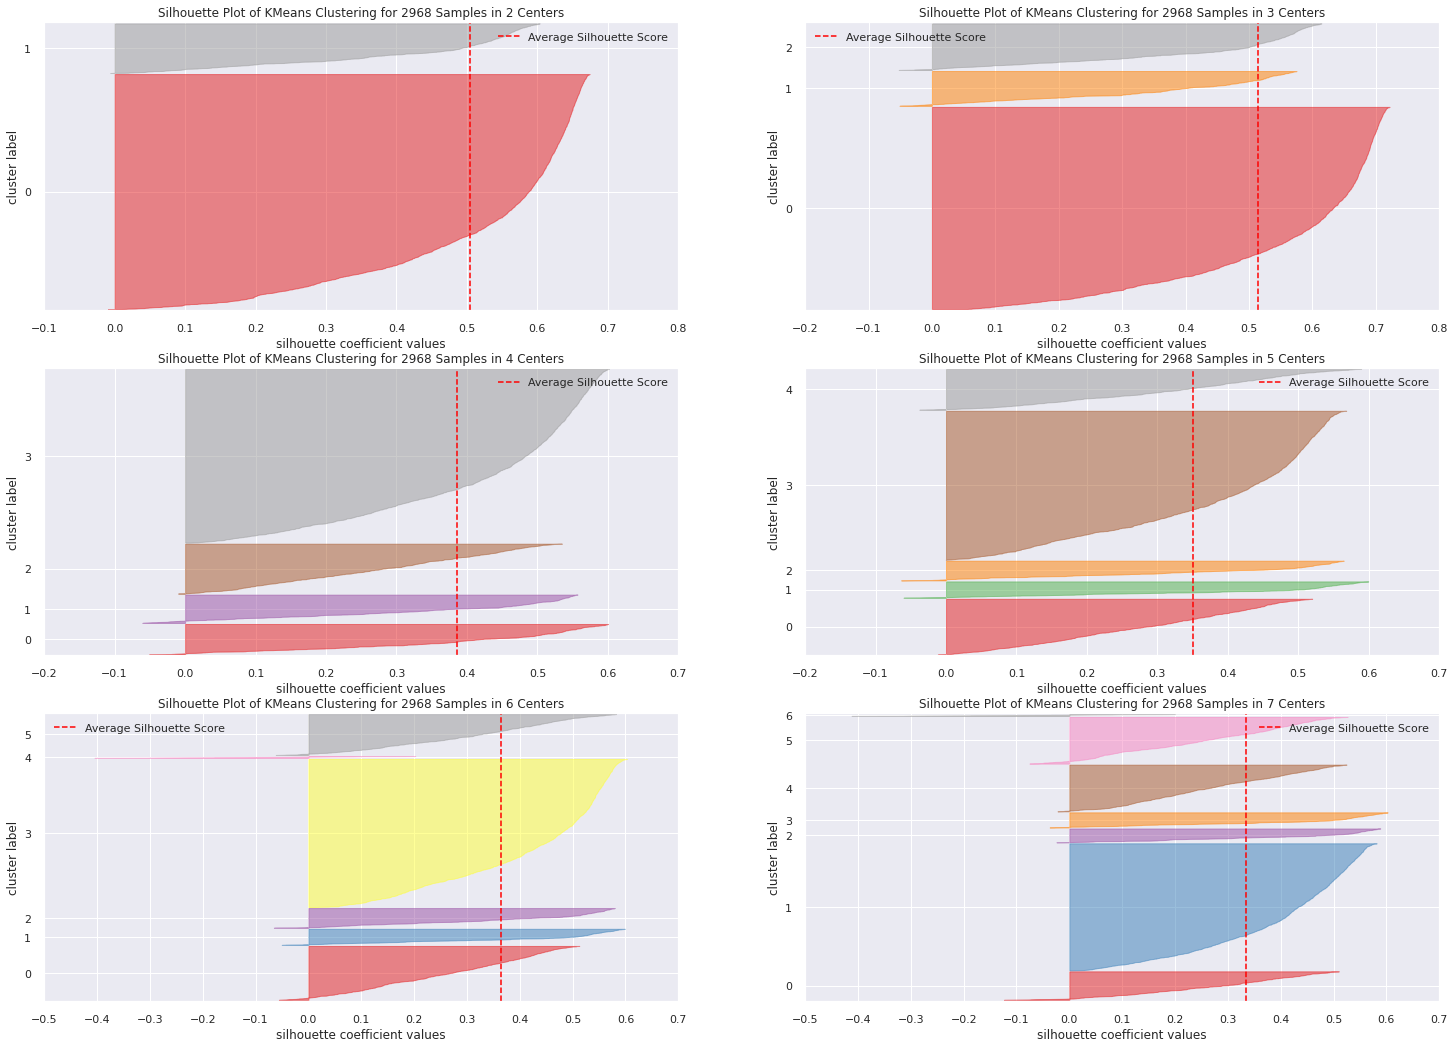

In [102]:
k=2

fig, ax = plt.subplots(3, 2, figsize=(25,18))
for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# Model Training

## K-Means

In [103]:
#model definition
k = 3
kmeans = c.KMeans(init ='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## Cluster Validation

In [104]:
#WSS (Within-cluster sum of square)
print('WSS value: {}'.format( kmeans.inertia_ ) )

# SS (Silhouette Score)
print('SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) ) 

WSS value: 105.7844001533094
SS value: 0.5147936838970257


# Cluster Analysis

In [105]:
df6.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.019292,0.997319,0.160976,0.008799,0.037774,0.003595,0.094521,1.000000,0.004438,0.008317,0.025896
1,13047,0.011559,0.150134,0.039024,0.007056,0.021695,0.003764,0.071918,0.001345,0.003883,0.025539,0.060260
2,12583,0.024000,0.005362,0.068293,0.025538,0.029479,0.006010,0.060788,0.002052,0.005547,0.055623,0.048431
3,13748,0.003375,0.254692,0.019512,0.002225,0.003446,0.007125,0.251142,0.000734,0.000000,0.014447,0.015400
4,15100,0.003116,0.892761,0.009756,0.000401,0.000255,0.065116,0.020822,0.003985,0.002441,0.004272,0.000000


In [106]:
df9 = df6.copy()
df9['clusters'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,clusters
0,17850,0.019292,0.997319,0.160976,0.008799,0.037774,0.003595,0.094521,1.000000,0.004438,0.008317,0.025896,2
1,13047,0.011559,0.150134,0.039024,0.007056,0.021695,0.003764,0.071918,0.001345,0.003883,0.025539,0.060260,0
2,12583,0.024000,0.005362,0.068293,0.025538,0.029479,0.006010,0.060788,0.002052,0.005547,0.055623,0.048431,0
3,13748,0.003375,0.254692,0.019512,0.002225,0.003446,0.007125,0.251142,0.000734,0.000000,0.014447,0.015400,0
4,15100,0.003116,0.892761,0.009756,0.000401,0.000255,0.065116,0.020822,0.003985,0.002441,0.004272,0.000000,2


## Vizualization Inspection

/home/alex/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


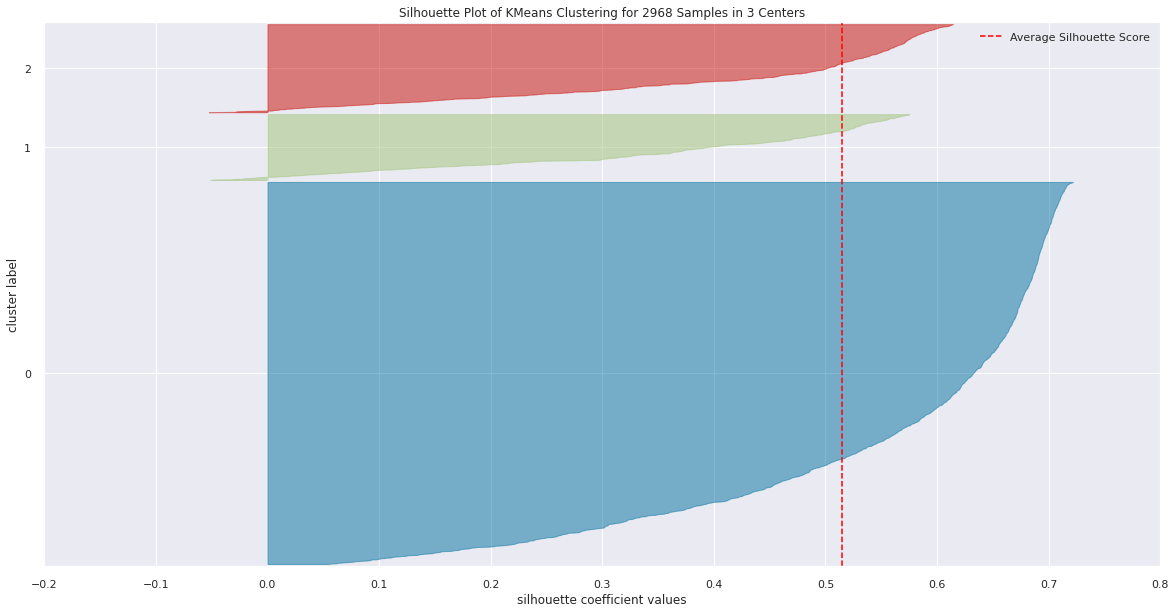

In [107]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='clusters')
#fig.show()

visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 2d Plot

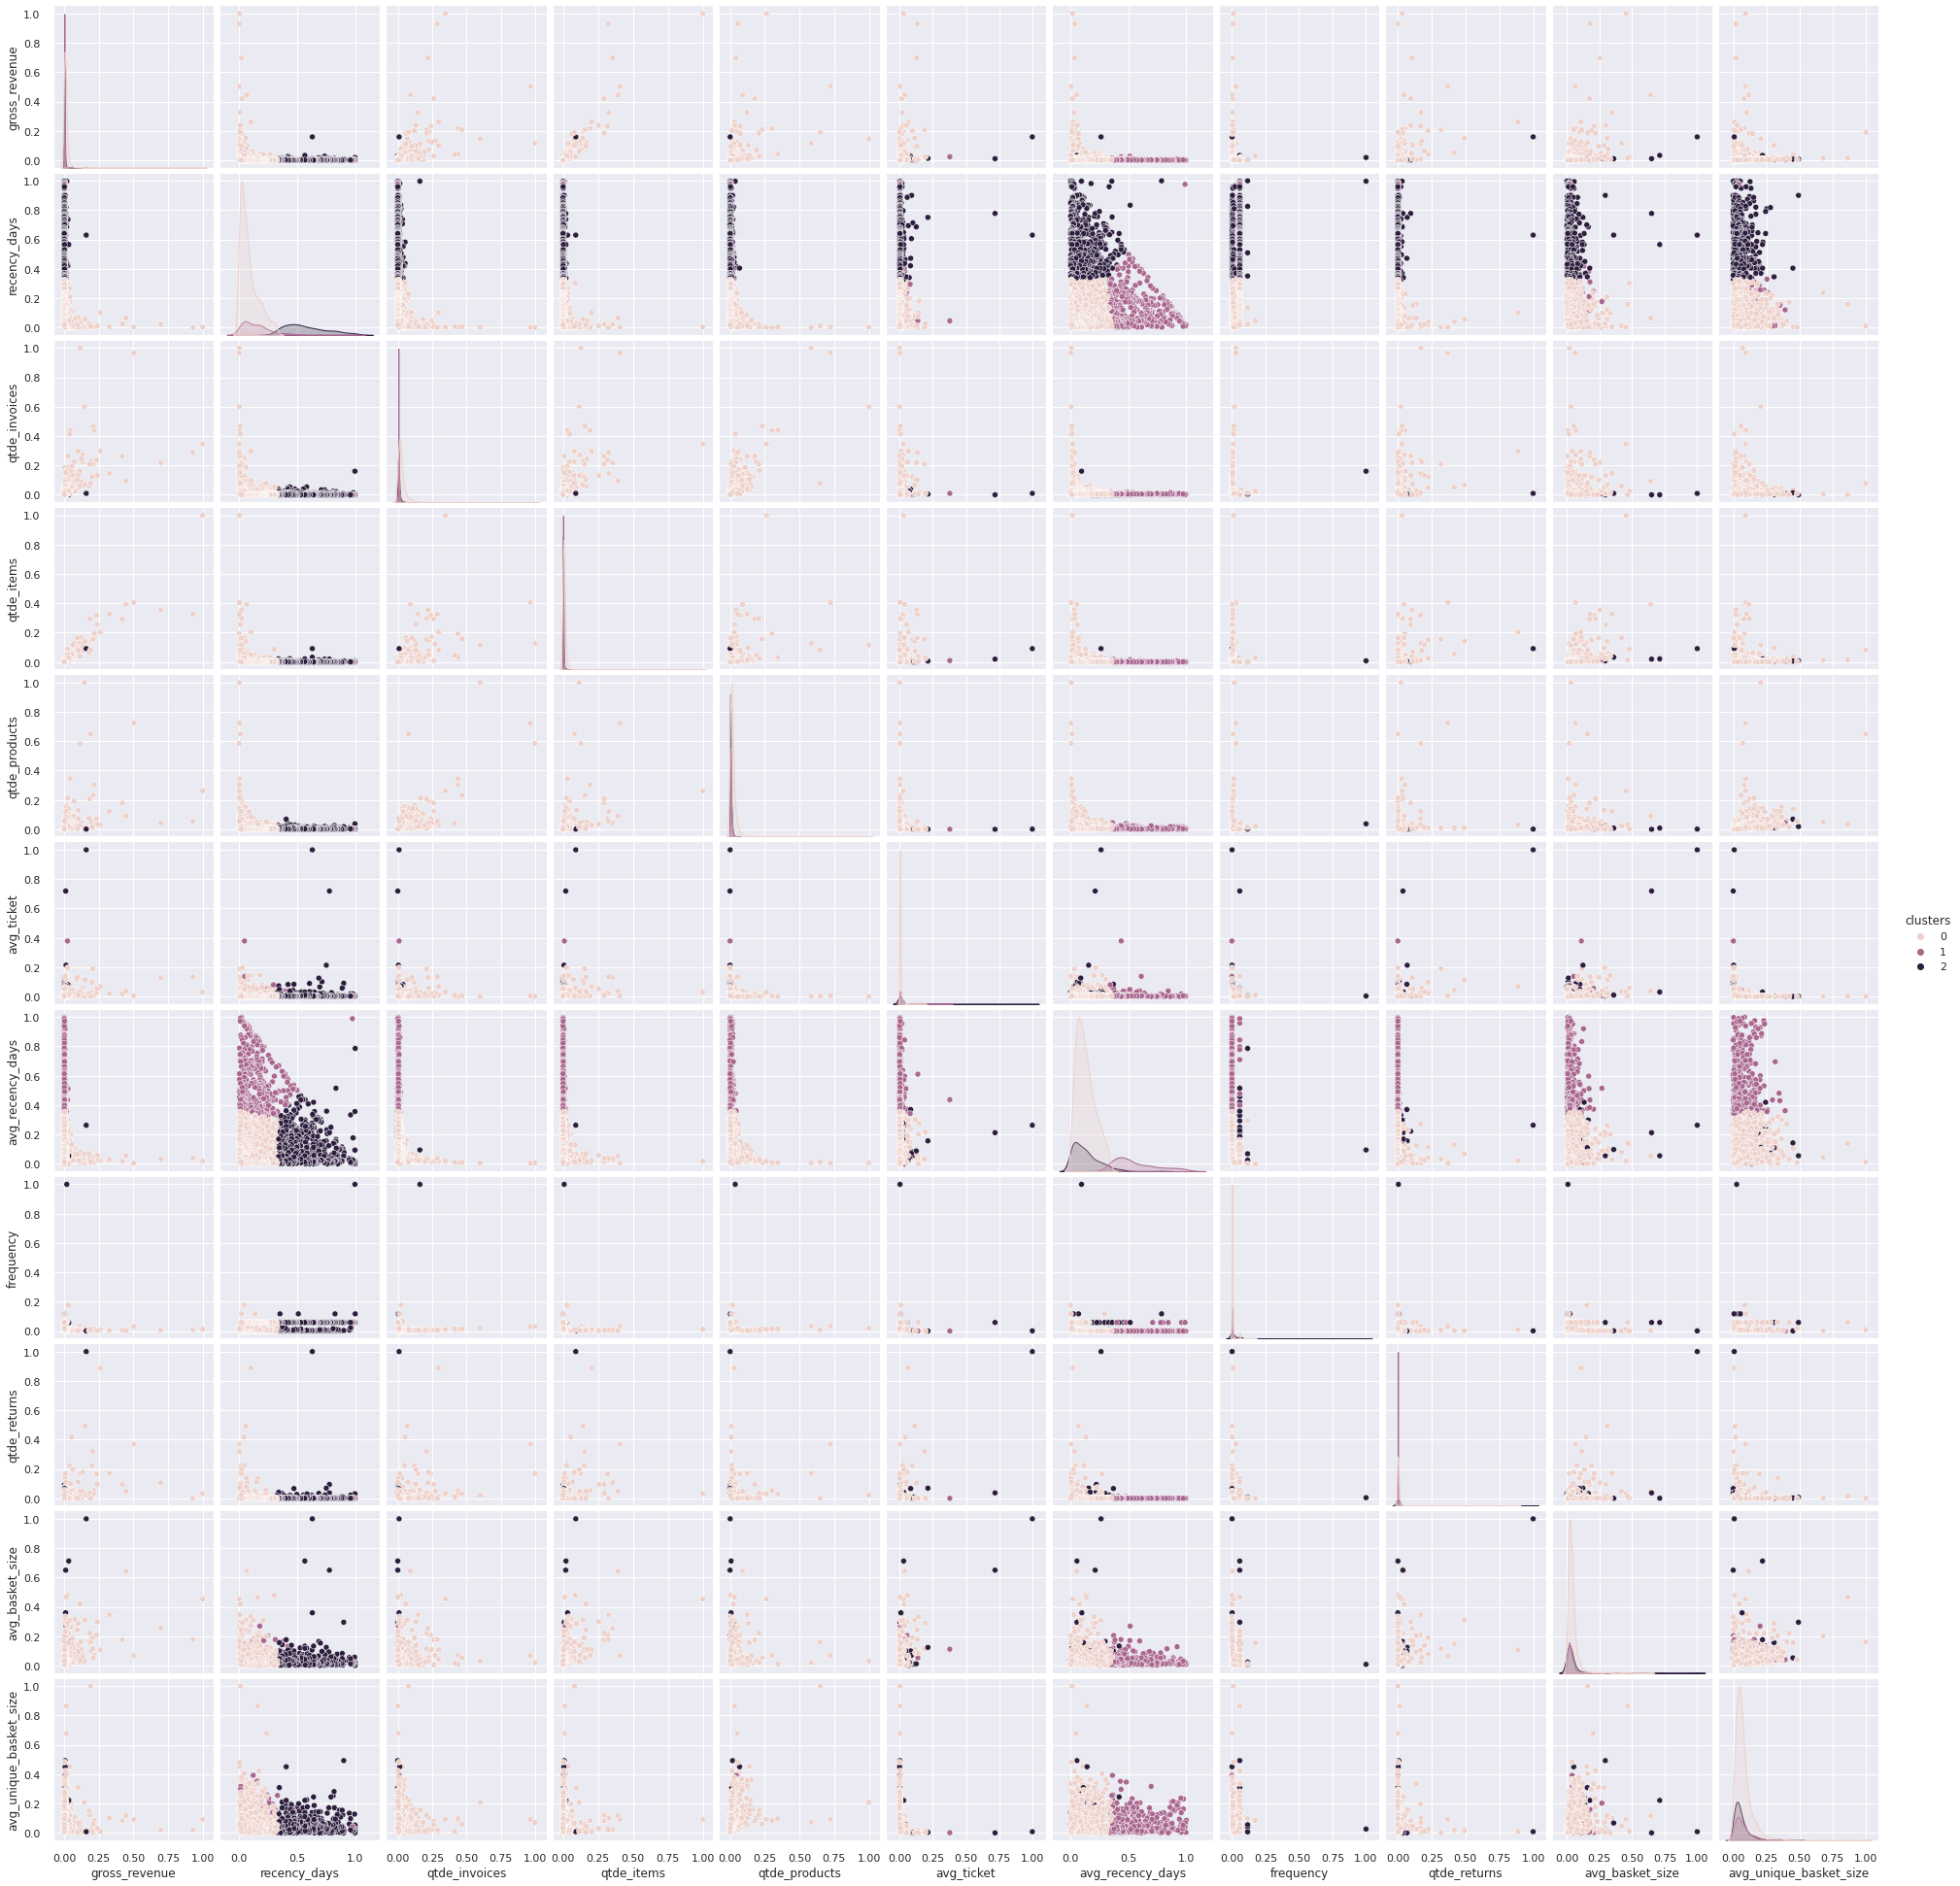

In [108]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='clusters')

## UMAP

Machine Learning - Mainfold
PCA - Matrix, Espaço de Distância - Espaço de Hilbert -  9 condições - Colorários

UMAP - t-SNE (2009) - Mainfold - Topologia

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

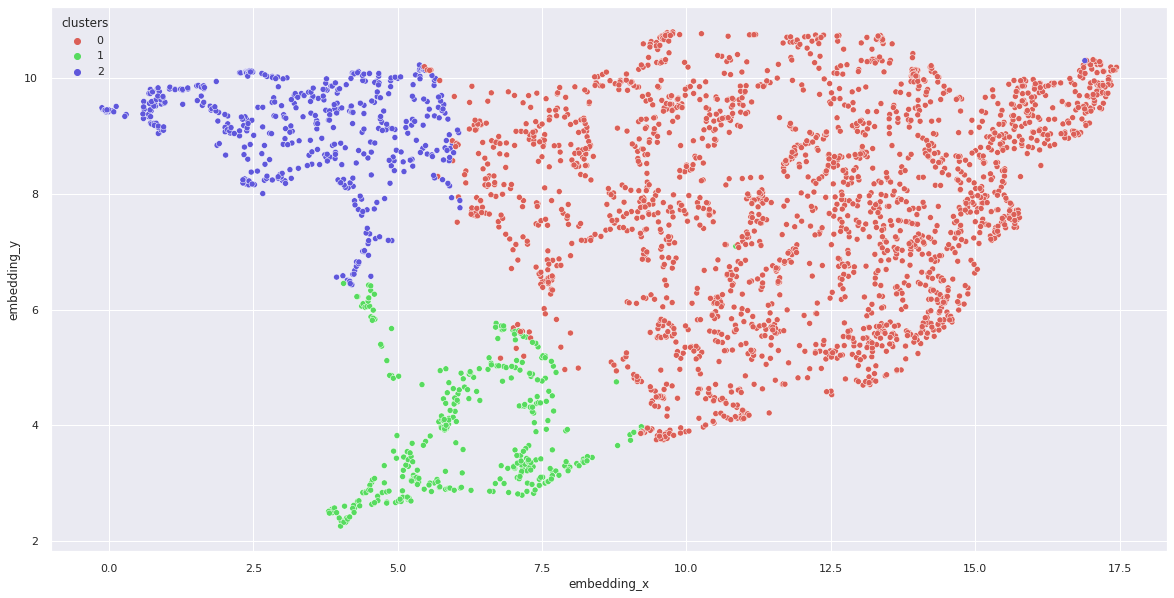

In [109]:
reducer = umap.UMAP( n_neighbors=20, random_state=42)
embedding = reducer.fit_transform( X )

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='clusters', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['clusters'].unique() )), data=df_viz)

## Cluster Profile

In [110]:
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,clusters
0,17850,0.019292,0.997319,0.160976,0.008799,0.037774,0.003595,0.094521,1.000000,0.004438,0.008317,0.025896,2
1,13047,0.011559,0.150134,0.039024,0.007056,0.021695,0.003764,0.071918,0.001345,0.003883,0.025539,0.060260,0
2,12583,0.024000,0.005362,0.068293,0.025538,0.029479,0.006010,0.060788,0.002052,0.005547,0.055623,0.048431,0
3,13748,0.003375,0.254692,0.019512,0.002225,0.003446,0.007125,0.251142,0.000734,0.000000,0.014447,0.015400,0
4,15100,0.003116,0.892761,0.009756,0.000401,0.000255,0.065116,0.020822,0.003985,0.002441,0.004272,0.000000,2


In [111]:
#Number of customer
df_cluster = df9[['customer_id', 'clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

#AVG Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='clusters')

#AVG recency days
df_avg_gross_days = df9[['recency_days', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_days, how='inner', on='clusters')

#AVG invoice_no
#df_avg_invoice_no = df9[['invoice_no', 'clusters']].groupby('clusters').mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='clusters')

#AVG ticket
df_ticket = df9[['avg_ticket', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='clusters')

In [112]:
df_cluster.head()
#gross_revenue = média de gastos
#recency_days = a cada X dias as pessoas estão fazendo compra
#invoice_no = compra em média X produtos


,clusters,customer_id,perc_customer,gross_revenue,recency_days,avg_ticket
0,0,2115,71.260108,0.012300,0.084648,0.006125
1,1,365,12.297844,0.002626,0.143369,0.006281
2,2,488,16.442049,0.003278,0.574518,0.010900


### Cluster 01: (Candidato a Insider)

- Número de customers: 6 (0.14% do customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

### Cluster 02:

- Número de customers: 31 (0.71% do customers)
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:

- Número de customers: 4335 (99,15% do customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1372,5 dólares